In [1]:
# Standard import(s)
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

In [3]:
def load_dataset():
    #
    num_snaps = 20000
    tdiff = 9.0
    grid_dataset_list = []
    file_index = 1
    alphas = np.linspace(0.2, 0.8, 4)
    betas = np.linspace(0.2, 0.8, 4)
    
    for alpha in alphas:
        for beta in betas:
            if alpha == 0.8 and beta == 0.2:
                pair = (round(alpha, 2), round(beta, 2))
                grid_pt_data = pd.read_csv("Length10RealTimeSnaps{}alpha{}beta{}tdiff{}.csv".format(num_snaps, pair[0], pair[1], tdiff), header=None)
                grid_pt_data['y'] = [file_index] * grid_pt_data.shape[0]
                grid_dataset_list.append(grid_pt_data)
                print('Alpha, Beta is {} and given label {}'.format(pair, file_index))
                file_index += 1
    
    grid_dataset = pd.concat(grid_dataset_list)

    X = grid_dataset.iloc[:, :-1]
    y = grid_dataset.iloc[:, -1]
    
    return X, y, file_index

In [4]:
X, y, file_index = load_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
print(X_train.shape)

Alpha, Beta is (0.8, 0.2) and given label 1
(10000, 10)


In [5]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [6]:
original_dim = 10
intermediate_dim = 7
intermediate_dim2 = 50
intermediate_dim3 = 25
latent_dim = 1

In [7]:
inputs = Input(original_dim, name='input')

x = Dense(intermediate_dim, activation='relu')(inputs)

# Means and log(variances) layers both connected to previous dense layer
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
# Lambda layer to sample z vector from distribution given by learned means and log(variances) using 'reparameterization trick'
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [8]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 7)            77          input[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 1)            8           dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 1)            8           dense[0][0]                      
____________________________________________________________________________________________

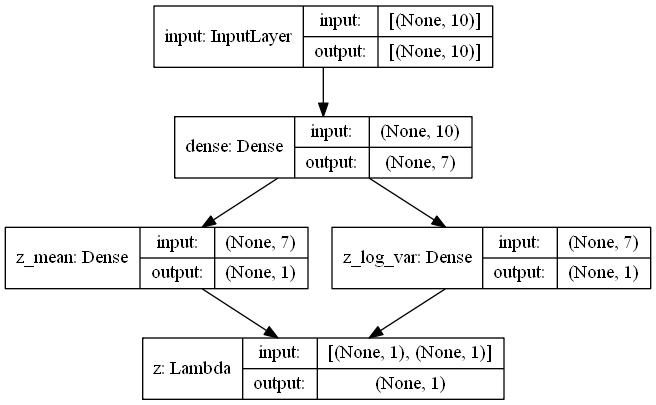

In [9]:
plot_model(encoder, show_shapes=True)

In [10]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(intermediate_dim, activation='relu')(latent_inputs)

outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')

In [11]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                80        
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


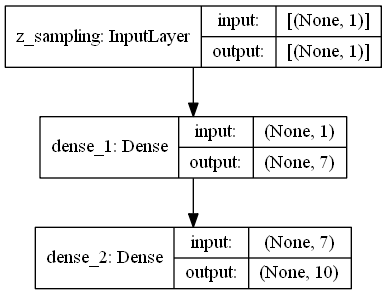

In [12]:
plot_model(decoder, show_shapes=True)

In [13]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
 i = i[0]
 pass
z = encoder(i)[2]
o = decoder(z)

In [14]:
vae = Model(i, o, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
encoder (Functional)         [(None, 1), (None, 1), (N 93        
_________________________________________________________________
decoder (Functional)         (None, 10)                94        
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


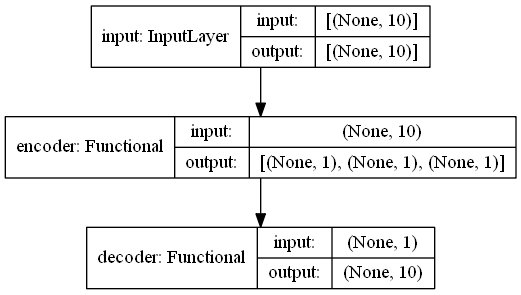

In [15]:
plot_model(vae, show_shapes=True)

In [16]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        #reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        reco_loss_value = K.sum(reco_loss_value)
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

In [17]:
# Define parameters
nb_epochs  =  10
batch_size = 32

In [18]:
# Compile with given compile function to include custom VAE loss function
compile_vae(vae)

vae_history = vae.fit(X_train, X_train,
                      epochs=nb_epochs,
                      batch_size=batch_size,
                      shuffle=True,
                      validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 1s 120us/sample - loss: 20.3902 - reco_loss: 19.8395 - kl_loss: 0.5508 - val_loss: 17.3667 - val_reco_loss: 16.5728 - val_kl_loss: 0.7259


C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 2/10
8000/8000 [==============================] - 1s 74us/sample - loss: 16.8746 - reco_loss: 16.1095 - kl_loss: 0.7650 - val_loss: 16.5321 - val_reco_loss: 15.7385 - val_kl_loss: 0.7305
Epoch 3/10
8000/8000 [==============================] - 0s 61us/sample - loss: 16.3032 - reco_loss: 15.6008 - kl_loss: 0.7025 - val_loss: 16.1548 - val_reco_loss: 15.4173 - val_kl_loss: 0.6765
Epoch 4/10
8000/8000 [==============================] - 1s 66us/sample - loss: 15.9941 - reco_loss: 15.3205 - kl_loss: 0.6736 - val_loss: 15.8975 - val_reco_loss: 15.1889 - val_kl_loss: 0.6466
Epoch 5/10
8000/8000 [==============================] - 1s 66us/sample - loss: 15.8080 - reco_loss: 15.1601 - kl_loss: 0.6480 - val_loss: 15.8186 - val_reco_loss: 15.0854 - val_kl_loss: 0.6566
Epoch 6/10
8000/8000 [==============================] - 1s 63us/sample - loss: 15.6763 - reco_loss: 15.0375 - kl_loss: 0.6387 - val_loss: 15.6501 - val_reco_loss: 14.9913 - val_kl_loss: 0.6024
Epoch 7/10
8000/8000 [=============

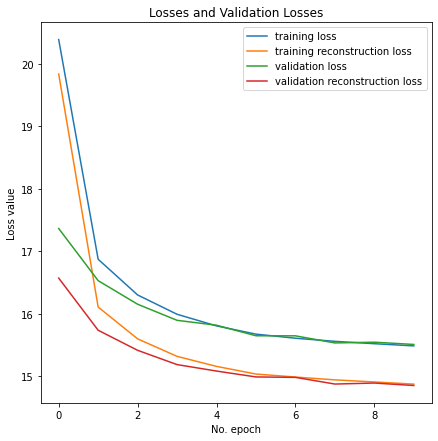

In [19]:
# Plot the two loss components and the total for both training and validation by epoch
plt.figure(figsize=(7, 7))
plt.plot(vae_history.history['loss'], label='training loss')
plt.plot(vae_history.history['reco_loss'], label='training reconstruction loss')
#plt.plot(vae_history.history['kl_loss'], label='training kl loss')
plt.plot(vae_history.history['val_loss'], label='validation loss')
plt.plot(vae_history.history['val_reco_loss'], label='validation reconstruction loss')
#plt.plot(vae_history.history['val_kl_loss'], label='validation kl loss')
plt.title('Losses and Validation Losses')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [20]:
z_mean, _, _ = encoder.predict(X_test)

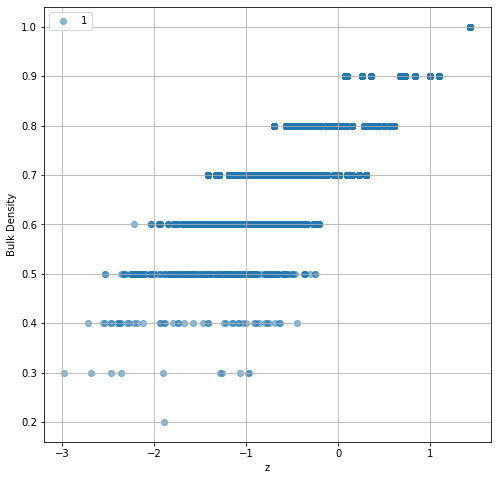

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax.scatter(single_label[:, 0],
               np.mean(X_test[mask], axis=1),
               label=t, alpha=0.5)
    pass

# Draw legend
ax.legend()
# Include grid lines to make chosen region of latent space clear
ax.grid()
ax.set_xlabel('z')
ax.set_ylabel('Bulk Density')

plt.show()

In [22]:
X_test_currents = []
for i in range(len(X_test)):
    jumps_possible = 0
    occs = np.array(X_test.iloc[i])
    for j in range(len(occs)): 
        if  j == len(occs)-1 and occs[j] == 1:
            jumps_possible += 1
        elif occs[j] == 1 and occs[j+1] == 0:
            jumps_possible += 1
    X_test_currents.append(jumps_possible / len(occs))
    
X_test_currents = np.array(X_test_currents)

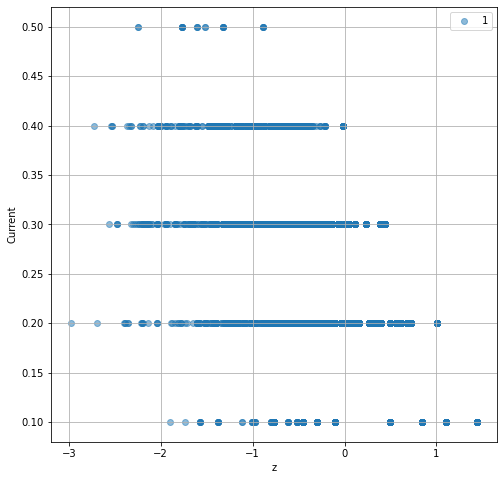

In [23]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax.scatter(single_label[:, 0],
               X_test_currents[mask],
               label=t, alpha=0.5)
    pass

# Draw legend
ax.legend()
# Include grid lines to make chosen region of latent space clear
ax.grid()
ax.set_xlabel('z')
ax.set_ylabel('Current')

plt.show()

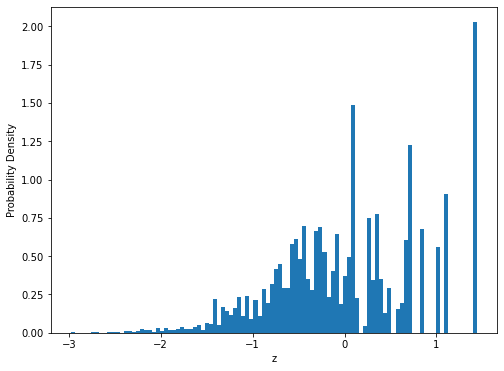

In [24]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
# Make histogram at the 
ax.hist(z_mean[:, 0],bins=100, density=True)

ax.set_xlabel('z')
ax.set_ylabel('Probability Density')

plt.show()

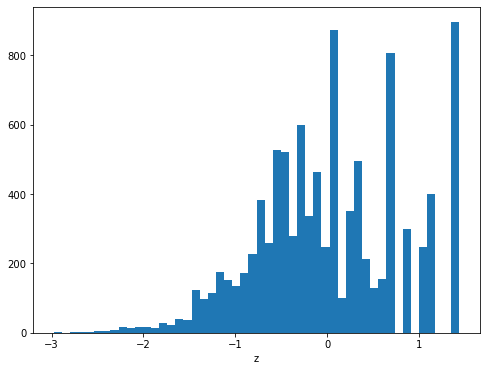

In [25]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax.hist(single_label[:, 0],
               bins=50)
    pass

ax.set_xlabel('z')

plt.show()

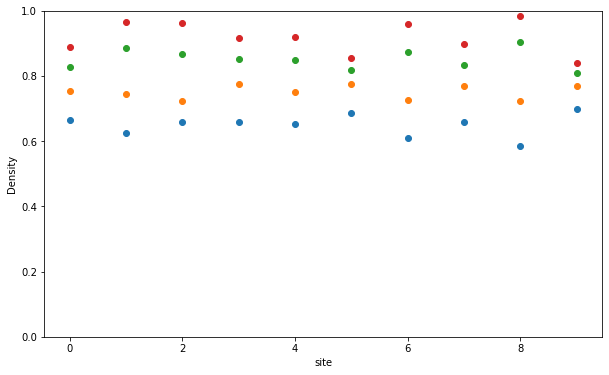

In [27]:
zs = np.array([-1.3, -0.4, 0.4, 1.3])
nb_show = 4
fig, ax = plt.subplots(1,1,figsize=(10,6))
for i in range(nb_show):
    ax.scatter(list(range(10)), decoder.predict(np.array([zs[i]])))
    ax.set_ylim(0, 1)
    ax.set_xlabel('site')
    ax.set_ylabel('Density')
plt.show()